# Unsupervised Algorithms in Machine Learning Final Project

I will be using the following dataset [Helpful Life Tips from Reddit](https://kaggle.com/datasets/asaniczka/helpful-life-tips-from-reddit-dataset-13k-tips) taken from Kaggle.com to either build a recommendation system that suggests relevant tips based on specific life situations or topics OR analyze popular life topics and their corresponding tips to uncover patterns and common themes.

The following description of the dataset was taken directly from the website:

About the Dataset:
Reddit is a treasure trove of genuine life experiences from millions of people. Subreddits like r/lifeProTips and r/YouShouldKnow are well-known for containing some of the best and most practical tips that anyone can apply to their life.

This dataset is a cleaned version of the split reddit dump by u/Watchful1.

The dataset has the following attributes:

"id" - Post id given by reddit. (type:str)

"author" - Creator of the post. (type:str)

"isOver18" - Whether the post is NSFW or not. (type:bool)

"postUrl"- URL for the actual reddit post. (type:str)

"subreddit" - Name of the subreddit the post was created on. (type:str)

"postTitle" - Title of the post. (type:str)

"hasPostBody" - Whether the post has a post body or not. (type:bool)

"postBody" - Body of the post. If null, post doesn't contain a body. (type:str)

"score" - Score of the post given by users. (type:int)

"numComments"- Number of comments in the original reddit post. (type:int)

## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
from pytest import approx

import warnings
warnings.filterwarnings("ignore")
import os
import pickle
import gzip


import re
import itertools as it

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid, train_test_split

import warnings 
warnings.filterwarnings('ignore')


/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#check we are in the right working directory
os.chdir('/Users/andreacruz/Documents/University of Colorado, Boulder MSDS/Machine Learning/Unsupervised Learning/Week 5')
os.getcwd()


'/Users/andreacruz/Documents/University of Colorado, Boulder MSDS/Machine Learning/Unsupervised Learning/Week 5'

Let's import the data and get an idea what we are working with...

In [6]:
#import data
reddit = pd.read_csv('helpfulRedditPosts.csv')
#look at basic info about the dataset
display(reddit.head())
display(reddit.shape)
print("how many post dont have any body text?", len(reddit[reddit['hasPostBody'] ==False]), "which is ", round((len(reddit[reddit['hasPostBody'] ==False])/len(reddit))*100,2),'% of the total dataset')

,id,author,isOver18,postUrl,subreddit,postTitle,hasPostBody,postBody,score,numComments
0,f6jt5e,w2555,False,https://reddit.com/r/LifeProTips/comments/f6jt5e/,LifeProTips,"LPT: keep your mouth shut, and don't volunteer...",True,I had a phone interview scheduled this morning...,147296,4730
1,lq1jn7,this1tyme,False,https://reddit.com/r/LifeProTips/comments/lq1jn7/,LifeProTips,"LPT: Texans, you are about to experience the w...",False,NaN,134320,4121
2,j2mm1b,raviji22,False,https://reddit.com/r/LifeProTips/comments/j2mm1b/,LifeProTips,"LPT: When you sign up for anything online, put...",False,NaN,129513,1971
3,fqkkke,[deleted],False,https://reddit.com/r/LifeProTips/comments/fqkkke/,LifeProTips,"LPT: First rule of family gatherings, always b...",True,[deleted],124219,2762
4,gmmiah,AlphaSyncz,False,https://reddit.com/r/YouShouldKnow/comments/gm...,YouShouldKnow,"YSK That there is a Youtuber called ""Dad, how ...",True,It's just basic stuff but I know friends of mi...,120038,1532


(13079, 10)

how many post dont have any body text? 3695 which is  28.25 % of the total dataset


Here we can see a preview of the dataframe that we are working with. The most promising fields that can be utilized for NLP text analysis seem to be "postTitle" and "postBody". Given that 28% of the total data set is missing a post Body, I will opt for using the postTitle. Let's see if there any other missing values...

In [7]:
#How many unique subreddits were these life tips taken from 
display(reddit['subreddit'].unique())
#any other columns with null values
display(reddit.isna().sum())

array(['LifeProTips', 'YouShouldKnow'], dtype=object)

id                0
author            0
isOver18          0
postUrl           0
subreddit         0
postTitle         0
hasPostBody       0
postBody       3695
score             0
numComments       0
dtype: int64

In [8]:
#let's split the dataset into training and testing sets
X_train, X_test = train_test_split(reddit, train_size=0.8, random_state= 101)

In [9]:
#reset indices for the training and testing set 
pd.DataFrame.reset_index(X_train, inplace = True, drop = True)
pd.DataFrame.reset_index(X_test, inplace = True, drop = True)
display(X_train.head())
display(X_test.head())

,id,author,isOver18,postUrl,subreddit,postTitle,hasPostBody,postBody,score,numComments
0,amlo7k,CanadianLemur,False,https://reddit.com/r/YouShouldKnow/comments/am...,YouShouldKnow,YSK that cold weather doesn't prevent sunburns.,True,With the cold weather and snow across North Am...,1454,60
1,2fxbsq,Hashi856,False,https://reddit.com/r/LifeProTips/comments/2fxbsq/,LifeProTips,LPT: Keep a couple of large trash bags in the ...,True,"If you're soaked from rain, have something gro...",2955,591
2,jhlp52,DeathAngel11,False,https://reddit.com/r/LifeProTips/comments/jhlp52/,LifeProTips,"LPT: If you tend to procrastinate, tell yourse...",False,NaN,33561,649
3,vco86c,Shallow-Thought,False,https://reddit.com/r/YouShouldKnow/comments/vc...,YouShouldKnow,YSK: Amazon delivery notes persist and are mos...,True,Why YSK: Clear and concise instructions will ...,10138,562
4,ueqq10,whizzaban,False,https://reddit.com/r/YouShouldKnow/comments/ue...,YouShouldKnow,YSK If you really feel the need to talk to som...,True,"**Why YSK:** Warm lines, unlike hotlines which...",12581,233


,id,author,isOver18,postUrl,subreddit,postTitle,hasPostBody,postBody,score,numComments
0,36taq3,zipzoobitybop,False,https://reddit.com/r/LifeProTips/comments/36taq3/,LifeProTips,"LPT: a Word file, is a zip in disguise.",True,Just rename your file from .docx to .zip and u...,5998,1016
1,npxwoy,mysterious_jedi,False,https://reddit.com/r/YouShouldKnow/comments/np...,YouShouldKnow,YSK: If you're picking someone up from the air...,True,Why YSK:\n\nFlying tends to dehydrate you beca...,2976,102
2,3yf03q,bcrabbers,False,https://reddit.com/r/LifeProTips/comments/3yf03q/,LifeProTips,"LPT: When packing up your Xmas lights, forget ...",True,I've been using this technique for the last 10...,2910,229
3,6ihcog,sfvalet,False,https://reddit.com/r/LifeProTips/comments/6ihcog/,LifeProTips,LPT- Dont buy a new car ever. As a former CPF ...,True,I used to work for UBS as a CFP before i went ...,19510,4095
4,uzxw9w,sleepapneaawareness,False,https://reddit.com/r/YouShouldKnow/comments/uz...,YouShouldKnow,"YSK If you sleep poorly, get tested for sleep ...",True,"\nWhy YSK, sleep apnea affects a [billion peop...",6133,538


## EDA and Data Preprocessing

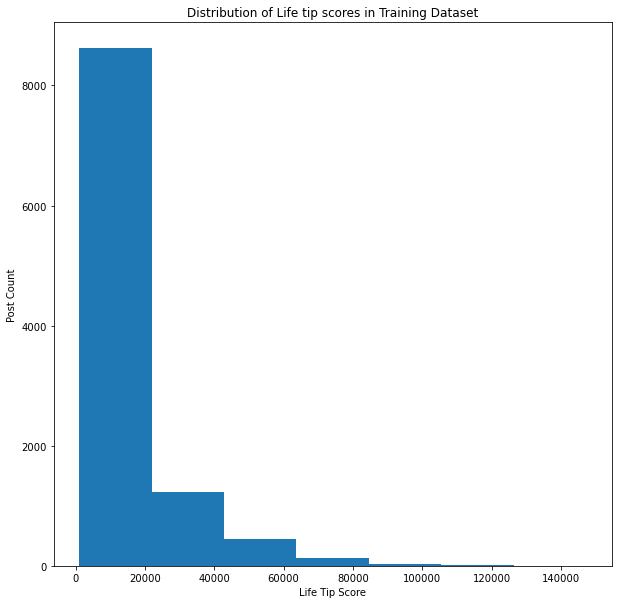

In [10]:
#taking a look a distribution of Scores of each post
fig, ax = plt.subplots(figsize =(10, 10))
n_bins = 7
ax.hist(X_train.score, bins = n_bins)

plt.xlabel("Life Tip Score")
plt.ylabel("Post Count")
plt.title('Distribution of Life tip scores in Training Dataset')

plt.show()
#looks like a majority of the scores fall in the 0-2000 range


In [11]:
#outlier scores
pd.set_option('display.max_rows', None)
print(len(X_train[X_train['score'] >40000]))
#scores >4000 seem to represent outliers of the dataset

print(round((len(X_train[X_train['score'] >40000])/len(X_train))*100,2),'% of dataset have scores >40000')
print("length of full dataset",len(X_train))
X_train = X_train[X_train['score'] <40000]
#confirm outliers were dropped
print("length of reduced dataset",len(X_train))

722
6.9 % of dataset have scores >40000
length of full dataset 10463
length of reduced dataset 9741


In [12]:
#Let's preview the postTitle column since we will be using this to perform NLP
X_train.postTitle[:5]

0      YSK that cold weather doesn't prevent sunburns.
1    LPT: Keep a couple of large trash bags in the ...
2    LPT: If you tend to procrastinate, tell yourse...
3    YSK: Amazon delivery notes persist and are mos...
4    YSK If you really feel the need to talk to som...
Name: postTitle, dtype: object

In [13]:
#lets remove punctuation, numbers, stop words, extra spaces
def cleanup_text(dataframe, text_col):
    #change all words to lowercase 
    dataframe['clean_text'] = dataframe[text_col].apply(lambda item: item.lower())
    #remove punctuation
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(r'[^\w\s]+', ' ',item))
    #remove stop words
    stop_words = stopwords.words('english')
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: " ".join([x for x in item.split() if x not in stop_words]))
    #remove numbers
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(r'[0-9]+', '',item))
    #remove extra spaces
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(' +', ' ', item))
    #remove words with less than 2 letters
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: ' '.join(word for word in item.split() if len(word) > 2))

    return dataframe

In [14]:
#apply clean up function
X_train_cp = cleanup_text(X_train, 'postTitle')

In [15]:
#now lets define a tokenize and lemmatizer function
lemm = WordNetLemmatizer()

def lemmenatize(text):
    lem = [lemm.lemmatize(item) for item in text] 
    return lem

def tokenize_lemmenatize(dataframe, text_col):
    #tokenize (reduce string to each word)
    dataframe['tockenize'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    #lemmatize (converting to root word)
    dataframe['lemmatize'] = dataframe['tockenize'].apply(lambda item: lemmenatize(item))
    #sort alphabetically
    #dataframe['lemmatize'] = dataframe['lemmatize'].apply(lambda item: sorted(item))
    #count number of words in string
    dataframe['num_words'] = dataframe['lemmatize'].apply(lambda strings: len(strings))

    return dataframe

In [16]:
X_train_cp = tokenize_lemmenatize(X_train_cp, 'clean_text')
print(X_train_cp.tockenize[5])
print(X_train_cp.lemmatize[5])

['lpt', 'obligated', 'support', 'friend', 'mlm', 'pyramid', 'scheme', 'need', 'host', 'parties', 'share', 'posts', 'model', 'try', 'stuff', 'let', 'feel', 'uncomfortable', 'say', 'product', 'interested', 'universally', 'support', 'things']
['lpt', 'obligated', 'support', 'friend', 'mlm', 'pyramid', 'scheme', 'need', 'host', 'party', 'share', 'post', 'model', 'try', 'stuff', 'let', 'feel', 'uncomfortable', 'say', 'product', 'interested', 'universally', 'support', 'thing']


In [17]:
#remove acronym associated with reddit subthread since it is already stored in a different attribute column
#we can add the acronyms to the stop_words when rerunning clean up on training sets by for the purpose to continue with lemmatized column, we will manually remove them here

for index, row in X_train.iterrows():
    lemmatized_list = row['lemmatize']
    new_lemmatized_list = [word for word in lemmatized_list if all(sub not in word.lower() for sub in ('lpt', 'ysk', 'ltp'))]
    
    X_train.at[index, 'lemmatize'] = new_lemmatized_list

# Assign the modified 'lemmatize' column back to the original DataFrame
X_train['lemmatize'] = X_train['lemmatize']


subset_strings = ['lpt', 'ysk', 'ltp']
contains_subset = any(any(any(subset in word.lower() for subset in subset_strings) for word in row) for row in X_train['lemmatize'])
if contains_subset:
    print(f"At least one string in the list contains at least one of the subset strings: {subset_strings}.")
else:
    print(f"No string in the list contains any of the subset strings: {subset_strings}.")

No string in the list contains any of the subset strings: ['lpt', 'ysk', 'ltp'].


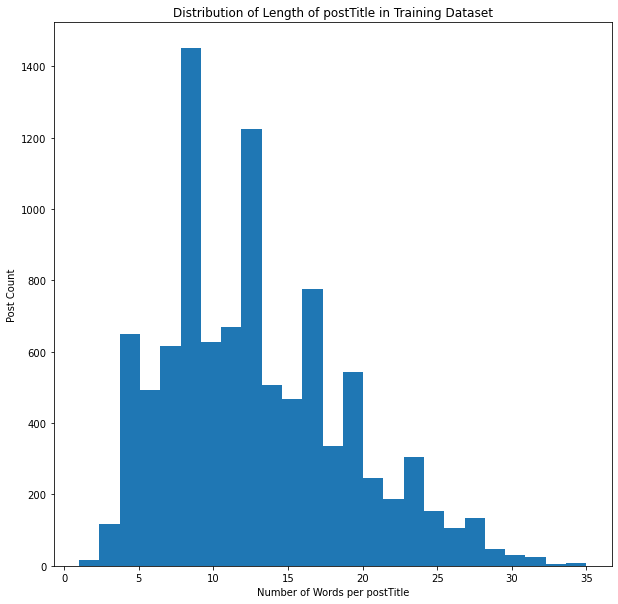

In [18]:
fig, ax = plt.subplots(figsize =(10, 10))
n_bins = 25
ax.hist(X_train.num_words, bins = n_bins)

plt.xlabel("Number of Words per postTitle")
plt.ylabel("Post Count")
plt.title('Distribution of Length of postTitle in Training Dataset')

plt.show()

In [19]:
#outlier titles
pd.set_option('display.max_rows', None)
display(X_train['lemmatize'][X_train['num_words'] >30])
#titles with greater than 30 words may have too many words and may indicate additional preprocessing may need to be done for condensed titles with more insightful words 



19       [making, excuse, leaving, party, early, use, o...
31       [moving, box, easily, found, free, might, brai...
194      [add, site, name, gmail, address, track, selli...
384      [everyone, time, valuable, start, amp, end, me...
402      [start, year, decade, right, state, mind, set,...
625      [oil, becomes, hot, cooking, creates, grease, ...
781      [avocado, taste, either, like, butter, pistach...
1359     [way, start, emergency, fund, open, new, bank,...
1548     [new, year, eve, place, second, behind, thanks...
1809     [buying, something, high, quality, prefer, mat...
2651     [never, buy, item, advertised, social, medium,...
3381     [instead, buying, non, essential, like, bigger...
3465     [applying, new, job, carefully, read, least, j...
3508     [someone, love, baby, soon, people, gift, newb...
4205     [calm, cry, baby, need, fed, changed, first, m...
4220     [app, freerice, quiz, app, run, united, nation...
4435     [comment, little, someone, eats, gathering, re.

In [38]:
#lets take a look at the most frequent words and decide if they are insightful enough to build topic models form or 
# if we need to do additionally preprocessing to get to that point
from collections import Counter

# Aggregating the lemm texts 
aggregated_texts= X_train_cp['lemmatize'].sum()
col_names = ['Word', 'POS']
agg_pos = pd.DataFrame(nltk.pos_tag(aggregated_texts),columns = col_names)

wordCounts = Counter(agg_pos['Word'])

# Identifying the 100 most frequently occurring words in each category
top_100_words = wordCounts.most_common(100)

# Displaying the 100 most frequently occurring words for each category
column_names = ["Word", "count"]
topWords = pd.DataFrame(top_100_words, columns = column_names)
mapping_dict = dict(zip(topWords['Word'], agg_pos['POS']))
topWords['POS'] = topWords['Word'].map(mapping_dict)
display(topWords)


,Word,count,POS
0,get,1019,NN
1,make,854,NN
2,someone,693,NN
3,one,630,NN
4,take,538,JJ
5,like,535,NN
6,need,487,JJ
7,something,470,NN
8,always,441,NN
9,want,441,NN


Based on this list we are able to identified additional stop words that dont provide much information for categorization which were removed from training dataset in clean_up function....including 'etc', 'let', 'say', try', 'put', 'ask', 'see', 'go', 'always', 'something', 'anything', 'get', 'one', 'like', 'someone'.

The count for 'le' seem to be indicating something is up with the clean_up/tockenization/lemmatization process because these aren't real words and even if they were they should have been removed in the clean_up section (since we remove words with less than 2 characters...) it looks like it may be occuring during tockenization/lemmatization...let's confirm this

In [21]:
value_to_search = 'le' 
indices = [index for index, value in enumerate(aggregated_texts) if value == value_to_search]
print(indices)
aggregated_texts[1500:1520]
#find more/less unique word sequence surounding 'le' to be able to search for 

[1513, 3019, 3022, 3782, 4214, 4689, 4943, 5324, 5327, 5443, 5515, 6655, 6808, 7170, 7447, 8151, 8900, 8953, 10780, 11569, 12174, 12687, 13442, 16624, 16625, 16855, 18206, 19012, 19400, 20465, 20596, 20664, 24560, 24562, 25480, 26625, 26819, 26906, 27238, 27310, 28259, 28423, 31021, 31033, 32202, 32800, 33204, 33271, 33388, 34683, 34957, 35164, 35183, 36413, 37440, 38198, 39266, 39633, 40539, 41906, 43610, 43749, 44471, 45450, 47297, 48075, 49396, 49422, 50657, 50662, 50915, 51599, 51656, 51659, 53723, 55020, 56050, 57507, 59045, 59185, 59618, 60137, 60332, 61519, 61913, 62716, 63119, 63330, 63965, 64482, 65088, 66403, 66434, 66439, 66853, 67016, 68073, 68796, 68851, 70823, 70960, 72042, 73143, 73153, 73516, 73954, 75197, 75339, 76521, 76524, 77368, 77463, 77577, 77581, 78534, 79043, 79809, 80376, 81021, 81129, 81263, 81465, 81927, 82699, 83697, 84220, 85742, 87193, 88569, 88836, 89244, 92003, 93113, 93273, 94180, 94965, 95222, 97625, 98225, 98770, 99071, 99073, 99570, 99744, 101623, 1

['go',
 'percent',
 'opposed',
 'say',
 'offer',
 'beer',
 'people',
 'working',
 'house',
 'instead',
 'far',
 'healthier',
 'far',
 'le',
 'risky',
 'offer',
 'coffee',
 'tea',
 'lemonade',
 'gatorade']

In [22]:

pd.set_option('display.max_rows', None)
substring_to_search = 'far healthier far'
test = X_train_cp[X_train_cp['clean_text'].str.contains(substring_to_search, case=False)].clean_text
test = X_train_cp['clean_text'][128]
print(test)



lpt opposed lpt says offer beer people working house instead far healthier far less risky offer coffee tea lemonade gatorade throughout day also homemade treats candy bars work wonders motivation


In [23]:
tester = pd.DataFrame({'clean_text':['far healthier far less risky offer']})
tester = tokenize_lemmenatize(tester, 'clean_text')
print(tester)

                           clean_text  \
0  far healthier far less risky offer   

                                   tockenize  \
0  [far, healthier, far, less, risky, offer]   

                                 lemmatize  num_words  
0  [far, healthier, far, le, risky, offer]          6  


We confirm that the weird word count is coming during the lemmatization. Luckily, it looks like this is a one off occurence and doesn't occur in the "clean_text" field, which is what will be used during topic modelling. Now let's look at the top 100 most common words and see if we need any of them to the stop words list (in addition to the acronyms used for the subreddits)

In [39]:
x = [3,6,11,12,15,26,27,29,31,36,38,45,46,47,50,54,55,58,60,63,68,69,71,72,73,78,80,82,83,85,86,88,97,98,99]
#display(topWords['Word'])
stop_add = topWords['Word']
for a in x:
    del stop_add[a]
stop_add = stop_add.values.tolist()
stop_add += ['lpt', 'ysk', 'ltp']
stop_add += ['things','thing', 'item', 'items', 'call', 'called', 'use', 'used', 'goes', 'idea', 'ideas', 'come', 'comes', 'possible', 'number', 'amp', 'different', 'difference', 'com','problem', 'actually','stuff', 'second','saying', 'say']
stop_add += ['wait', 'day','days','week','weeks','month','months','year','years','time','times','likely','bring','bag','create','minute','minutes','hour','hours','really','easy','hard','ask','asking','look','looking','one', 'two']
print(len(stop_add))

119


In [25]:
#redefine clean_text function to append stop_words list
def cleanup_text(dataframe, text_col, stop_add):
    #change all words to lowercase 
    dataframe['clean_text'] = dataframe[text_col].apply(lambda item: item.lower())
    #remove punctuation
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(r'[^\w\s]+', ' ',item))
    #remove stop words
    stop_words = stopwords.words('english')
    #these words are added from initial preprocessing
    added_list = stop_add
    stop_words.extend(added_list)
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: " ".join([x for x in item.split() if x not in stop_words]))
    #remove numbers
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(r'[0-9]+', '',item))
    #remove extra spaces
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(' +', ' ', item))
    #remove words with less than 2 letters
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: ' '.join(word for word in item.split() if len(word) > 2))

    return dataframe

In [40]:
X_train_ncp = cleanup_text(X_train, 'postTitle',stop_add)
X_train_ncp = tokenize_lemmenatize(X_train_ncp, 'clean_text')


In [41]:
aggregated_texts= X_train_ncp['lemmatize'].sum()
col_names = ['Word', 'POS']
agg_pos = pd.DataFrame(nltk.pos_tag(aggregated_texts),columns = col_names)

wordCounts = Counter(agg_pos['Word'])

# Identifying the 100 most frequently occurring words in each category
top_100_words = wordCounts.most_common(100)

# Displaying the 100 most frequently occurring words for each category
column_names = ["Word", "count"]
topWords = pd.DataFrame(top_100_words, columns = column_names)
mapping_dict = dict(zip(topWords['Word'], agg_pos['POS']))
topWords['POS'] = topWords['Word'].map(mapping_dict)
display(topWords)

,Word,count,POS
0,one,630,NN
1,people,596,NN
2,need,487,NN
3,work,461,NN
4,free,436,JJ
5,know,403,NN
6,keep,400,JJ
7,instead,353,NN
8,car,334,NN
9,life,329,NN


## Model Implementation and Evaluation

In [42]:
#preprocessing for feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Initializing the TF-IDF vectorizer 
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=4, stop_words="english")

# Applying TF-IDF vectorization to the cleaned text data
X_tfidf = tfidf_vectorizer.fit_transform(X_train_ncp['clean_text'])

# Displaying the shape of the resulting TF-IDF matrix
X_tfidf.shape

(9741, 4197)

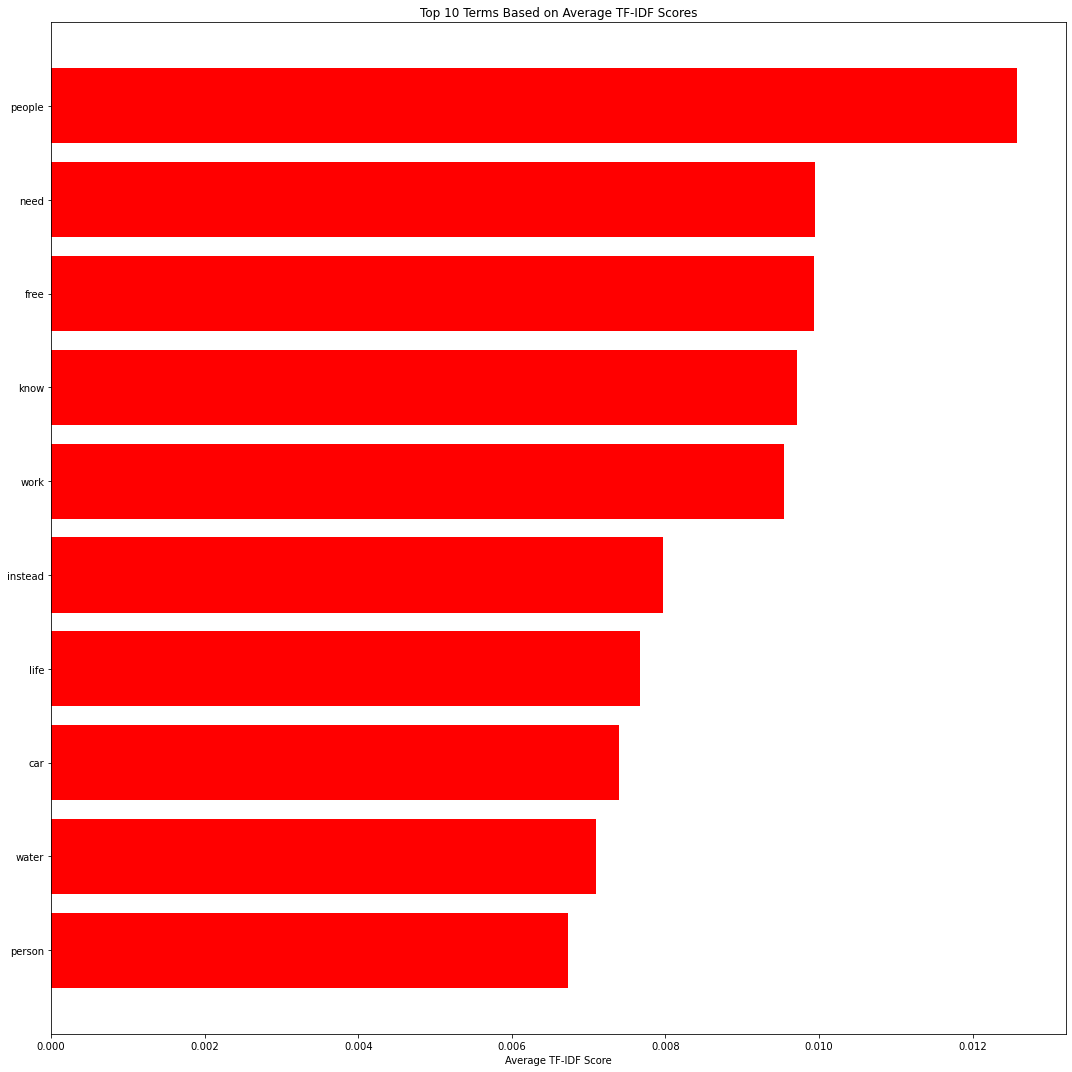

In [88]:
#plot the top 10 terms based on the average TF-IDF Scores
fig, axes = plt.subplots(figsize=(15, 15))
top_terms_tfidf = {}

top_n_terms = 10

feature_names = tfidf_vectorizer.get_feature_names_out()

avg_tfidf_scores = X_tfidf.mean(axis=0).A1
top_terms = np.argsort(avg_tfidf_scores)[-top_n_terms:]
top_terms_tfidf= [(feature_names[i], avg_tfidf_scores[i]) for i in top_terms]


top_terms = top_terms_tfidf[:top_n_terms]
term_names = [term[0] for term in top_terms]
term_scores = [term[1] for term in top_terms]
# Creating a bar plot 
ax = axes
ax.barh(term_names, term_scores, color='red')
ax.set_title(f'Top {top_n_terms} Terms Based on Average TF-IDF Scores')
ax.set_xlabel('Average TF-IDF Score')


plt.tight_layout()
plt.show()

In [30]:
#function to plot the top 10 words in each topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

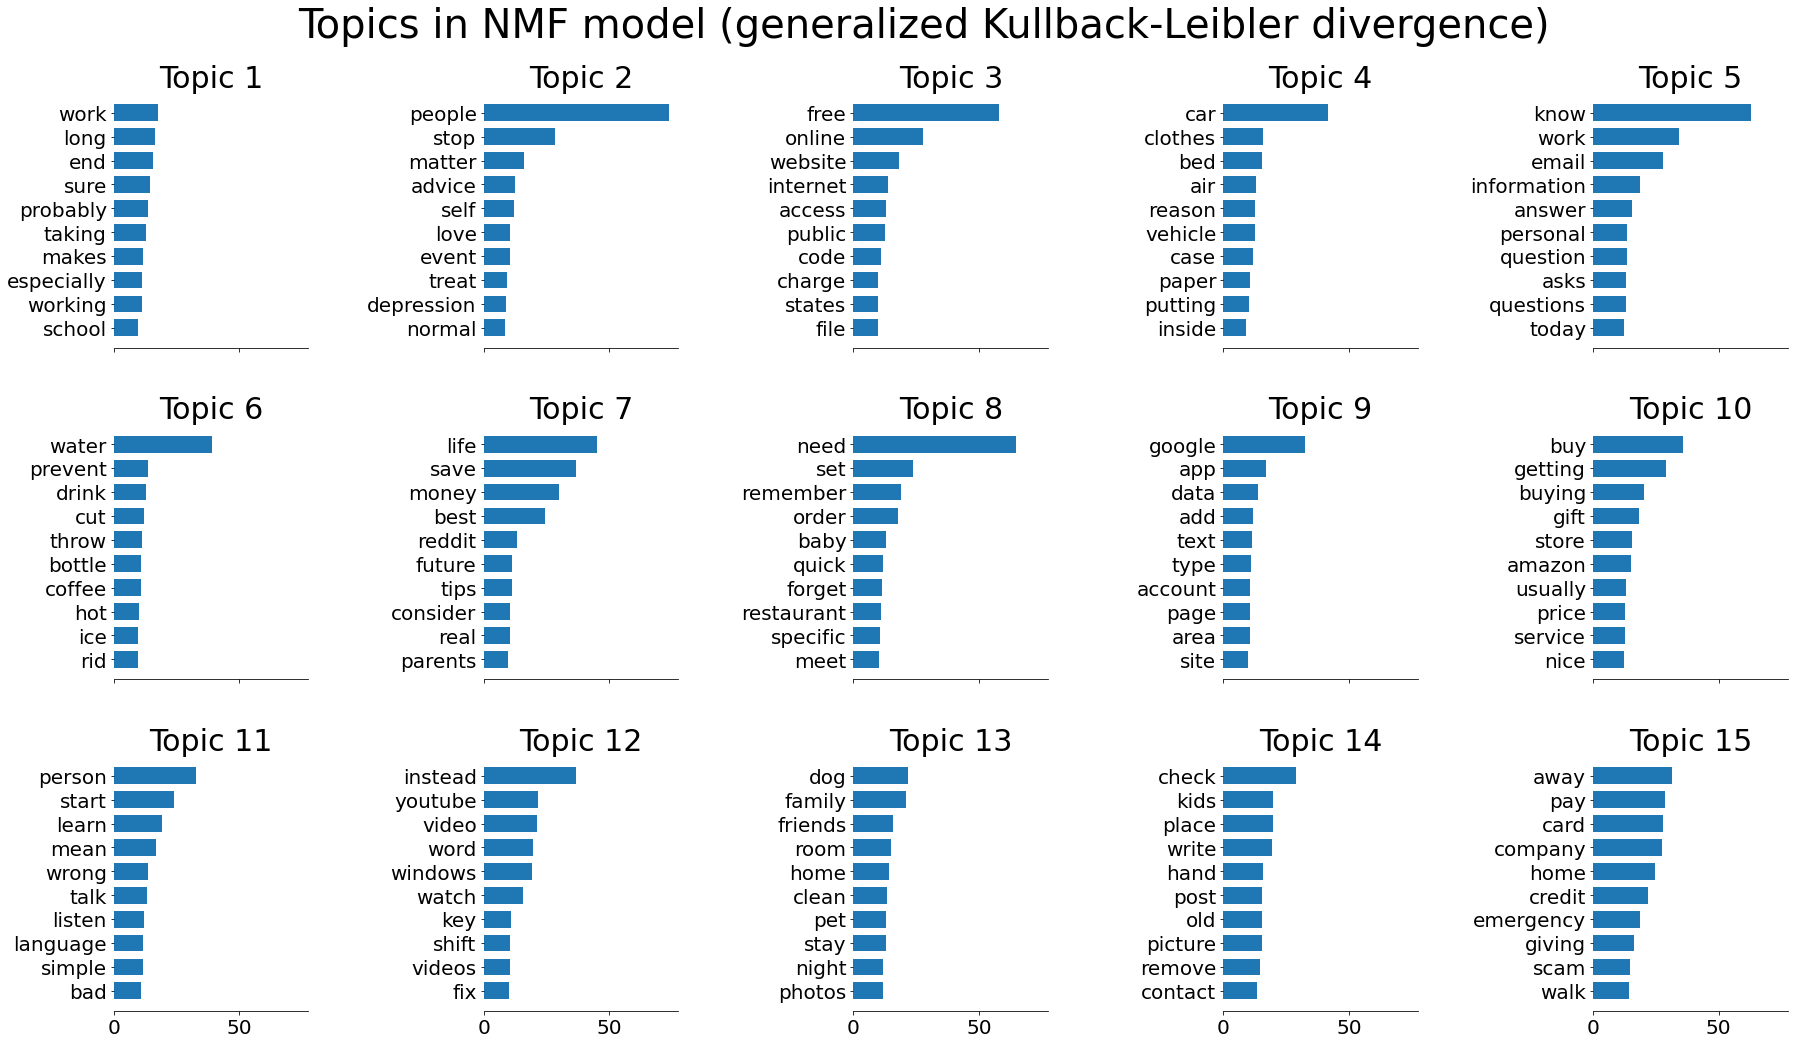

In [56]:
#apply NMF model & display top words per topic
nmf = NMF(alpha_H=0, alpha_W=1.0, beta_loss='kullback-leibler', init='nndsvda',
    l1_ratio=0, max_iter=1000, n_components=15, solver='mu', random_state=101).fit(X_tfidf)
plot_top_words(nmf,feature_names,top_n_terms,"Topics in NMF model (generalized Kullback-Leibler divergence)")

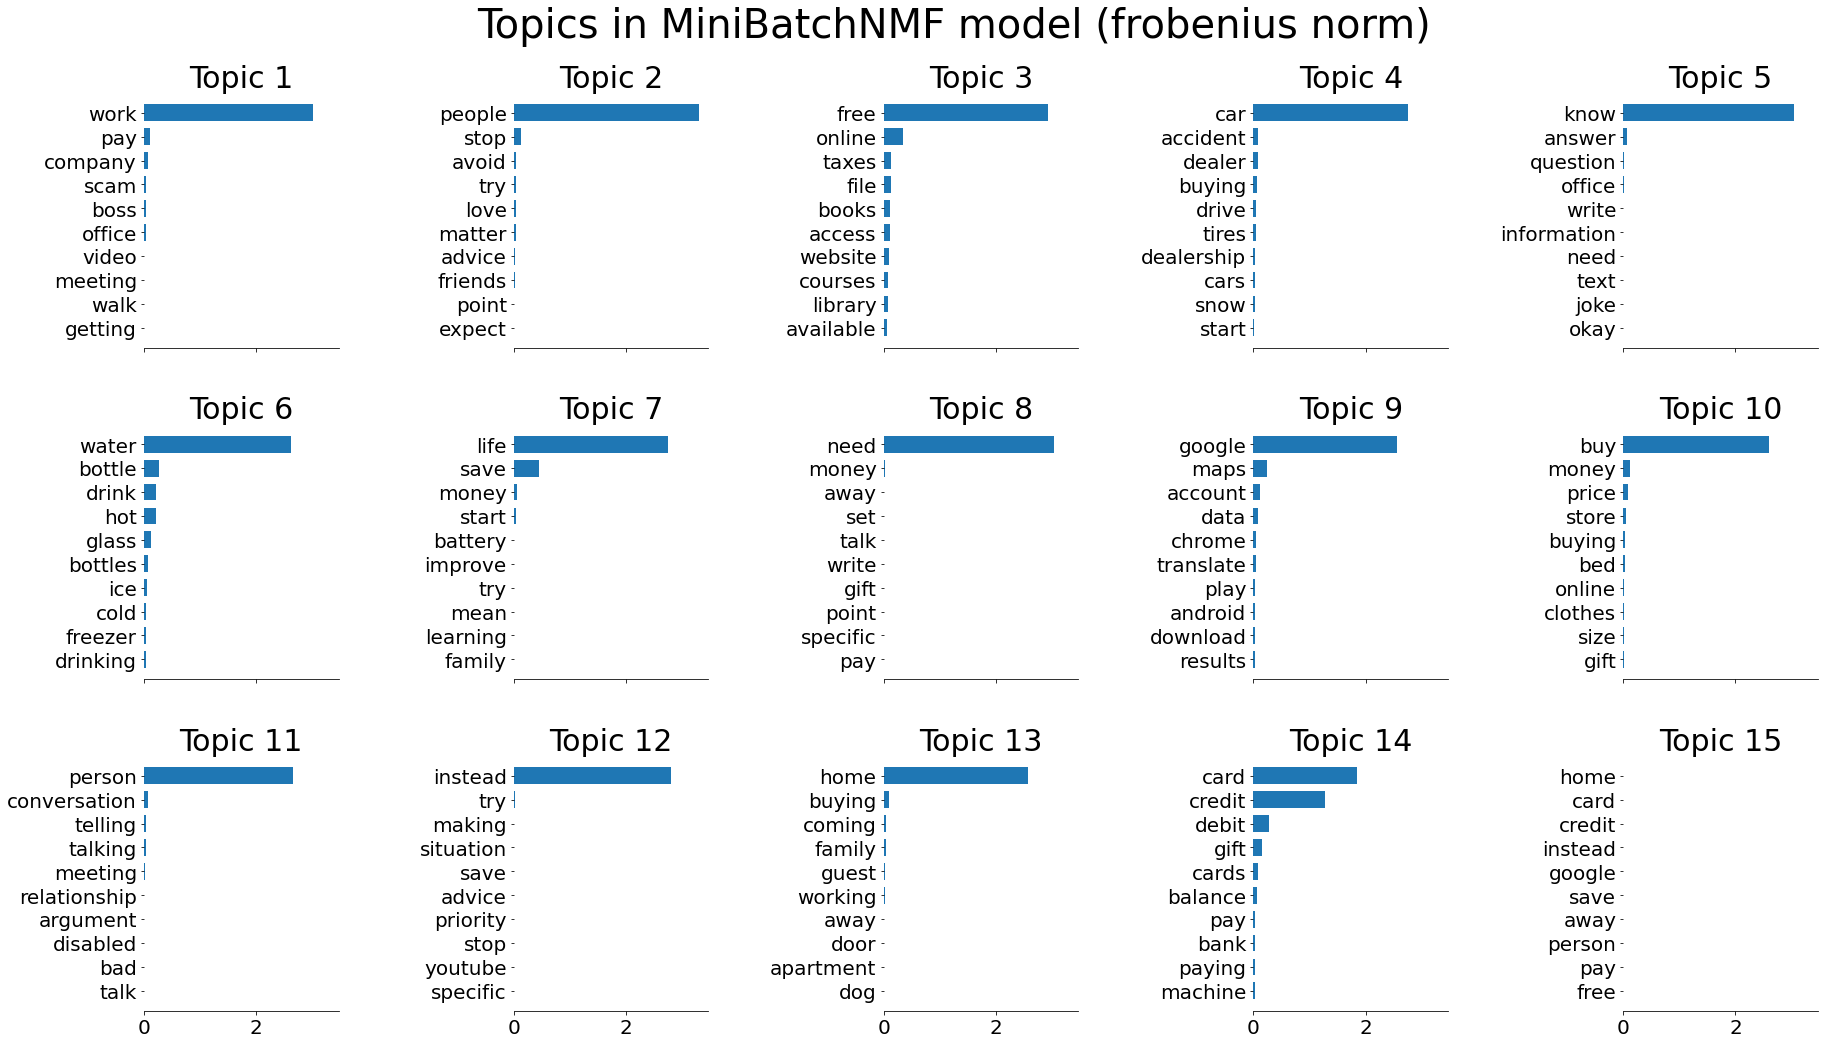

In [45]:
#apply minibatchNMF & display top words per topic
mbnmf = MiniBatchNMF(n_components=15, random_state=101, init='nndsvdar', beta_loss="frobenius",alpha_W=0.00005,alpha_H=0.00005, l1_ratio=0.5).fit(X_tfidf)
plot_top_words(mbnmf,feature_names,top_n_terms,"Topics in MiniBatchNMF model (frobenius norm)")

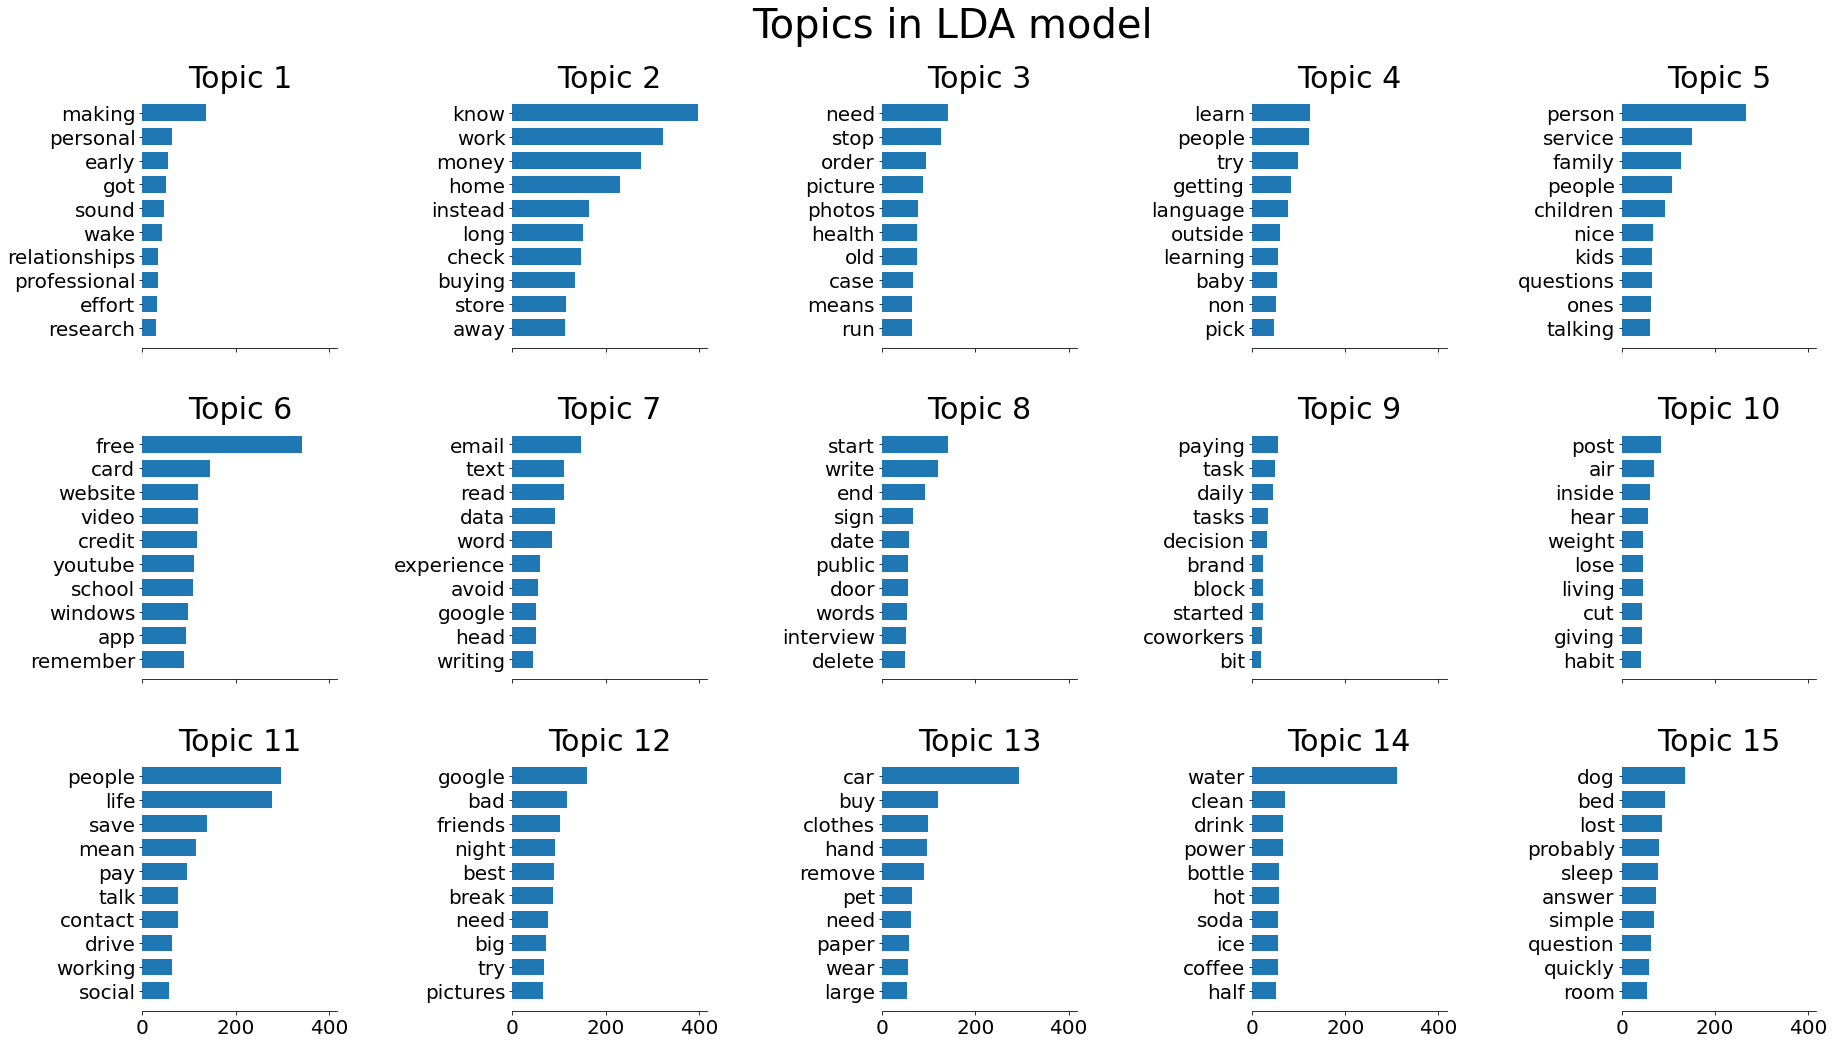

In [52]:
#apply LDA model & display top words per topic
CV_vectorizer = CountVectorizer(
    max_df=0.85, min_df=4, stop_words="english"
)
CV_data = CV_vectorizer.fit_transform(X_train_ncp['clean_text'])

feature_names = CV_vectorizer.get_feature_names_out()
top_n_terms = 10

lda = LatentDirichletAllocation(
    n_components=15,
    max_iter=10,
    learning_method="online",
    learning_offset=100.0,
    random_state=101,
)
lda.fit(CV_data)
plot_top_words(lda,feature_names,top_n_terms,"Topics in LDA model")

## NMF Model Evaluation

In [59]:
#function to predict topic assignment
def predict(NMFmatrix):
    indices_of_max_values = np.argmax(NMFmatrix, axis=1)
    return indices_of_max_values

In [74]:
#map model identified topics to human interpretted categories
label_dict = {}
cats = ['Work', 
        'Friendship/relationship', 
        'WWW.Com', 
        'Automobile', 
        'General Knowledge',
        'Drinks', 
        'Finances', 
        'Memory',
        'Internet',
        'Shopping', 
        'Communication', 
        'Online Videos',
        'Home',
        'Social Media',
        'Home Finances']
for i in range(15):
    label_dict[i] = cats[i]

print(label_dict)

{0: 'Work', 1: 'Friendship/relationship', 2: 'WWW.Com', 3: 'Automobile', 4: 'General Knowledge', 5: 'Drinks', 6: 'Finances', 7: 'Memory', 8: 'Internet', 9: 'Shopping', 10: 'Communication', 11: 'Online Videos', 12: 'Home', 13: 'Social Media', 14: 'Home Finances'}


In [75]:
#assign topics to each post
topic_assign = predict(nmf.transform(X_tfidf))
X_copy = X_train_ncp.copy()
X_copy['Topic'] = topic_assign
X_copy['Topic']= X_copy['Topic'].map(label_dict)

In [65]:
#print out examples of posts assigned to each topic
X_copy[X_copy['Topic'] == 'Drinks']['postTitle'][24]

'LPT if you have bagels about to expire and you plan on freezing them cut them first'

Based on the results of initially combing through posts assigned to certain categories, it seems that the model did do a good job of assigning some posts and others not so well. There is definetely room for improvement in the model training to hone these topics better. It's also possible that the topic name that I assigned for each was not reflective of the top terms which is a disadvantage of unsupervised learning and to be expected. Despite those opportunities, let's evaluate the LDA model additionally to see if there is better luck.

## LDA Model evaluation

In [66]:
#function to predict topic assignment
def predict_LDA(LDAmatrix):
    indices_of_max_values = np.argmax(LDAmatrix, axis=1)
    return indices_of_max_values

In [77]:
#map model identified topics 
label_dict_LDA= {}
cats = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for i in range(10):
    label_dict_LDA[i] = cats[i]

print(label_dict_LDA)

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10}


In [78]:
#assign topics to each post
topic_assign_LDA = predict(lda.transform(X_tfidf))
X_copy_LDA = X_train_ncp.copy()
X_copy_LDA['Topic'] = topic_assign_LDA
X_copy_LDA['Topic']= X_copy_LDA['Topic'].map(label_dict_LDA)

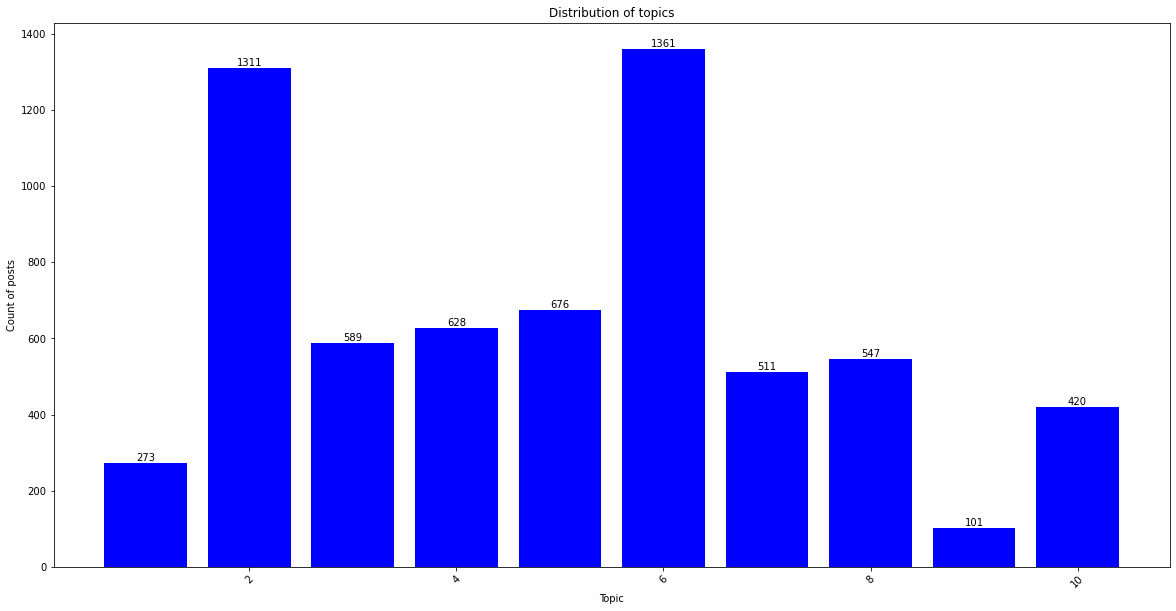

In [79]:
#plot distribution of topic categories

X_copy_LDA_cat = pd.DataFrame(X_copy_LDA['Topic'].value_counts())
X_copy_LDA_cat["% of posts"] = round((X_copy_LDA_cat['count']/sum(X_copy_LDA_cat['count']))*100,2)


fig, ax = plt.subplots(figsize = (20, 10))
bars = ax.bar(X_copy_LDA_cat.index, X_copy_LDA_cat['count'], color = 'blue')
ax.bar_label(bars)

plt.xlabel("Topic")
plt.xticks(rotation=45)
plt.ylabel("Count of posts")
plt.title("Distribution of topics")
plt.show()

In [81]:
X_copy_LDA[X_copy_LDA['Topic'] == 2]['postTitle']

10       LPT: put the self checkout at Kroger (or any g...
31       YSK moving boxes can easily be found for free....
61       YSK when to use 'de-stigmatize' instead of 'no...
63       LPT: During this shopping season don't forget ...
94       LPT: Be wary of any product which advertises t...
98       LPT: If you live far away from a young family ...
110      YSK: Nearly 1.7 million jack stands sold by Ha...
119      LPT: Look for the shady spot when you're leavi...
122      LPT: Always look people in the eye when saying...
125      LPT: If you see an item on sale, (such a €100 ...
128      LPT: As opposed to what the other LPT says, do...
132      LPT: If an app asks you to rate it but you don...
134      LPT: How to clear out a party and clean it up ...
156          YSK about the Amazon scam known as "Brushing"
160      LPT: Use Starbucks to get rid of foreign currency
162      LPT: When completing work from home, change in...
170      YSK that amazon’s reviews are no longer averag.

Unfortunately, this implementation with scikit-learn did not provide any thing remotely easily interpretable to name each topic. I decided to try to implement LDA with the gensim library to utilize the pyLDAvis module. My hope was that this would help with interpretation and visualization of the model...

In [ ]:
#returns array with the probability that the post belongs to given topic
lda.fit_transform(CV_data)

## Alt LDA implmentation

In [82]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint


import pickle
import re
import pyLDAvis
import pyLDAvis.gensim

In [83]:
# Create a dictionary representation of the documents.
id2word = Dictionary(X_train_ncp['lemmatize'])
# Bag of words representation of each doc 
corpus = [id2word.doc2bow(text) for text in X_train_ncp['lemmatize']]

print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))


Number of unique tokens: 11492
Number of documents: 9741


In [86]:
#implment LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=7,
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
pprint(doc_lda)

[(0,
  '0.027*"water" + 0.016*"website" + 0.015*"gift" + 0.013*"mean" + '
  '0.011*"school" + 0.010*"information" + 0.009*"tip" + 0.009*"experience" + '
  '0.009*"cost" + 0.009*"future"'),
 (1,
  '0.028*"life" + 0.022*"try" + 0.021*"car" + 0.016*"save" + 0.016*"could" + '
  '0.014*"every" + 0.013*"keep" + 0.011*"word" + 0.011*"around" + '
  '0.011*"stop"'),
 (2,
  '0.022*"know" + 0.019*"home" + 0.015*"one" + 0.014*"keep" + 0.014*"check" + '
  '0.014*"place" + 0.013*"etc" + 0.013*"buy" + 0.011*"need" + 0.011*"online"'),
 (3,
  '0.030*"work" + 0.029*"free" + 0.016*"store" + 0.014*"show" + 0.014*"email" '
  '+ 0.013*"easily" + 0.010*"family" + 0.010*"long" + 0.010*"le" + '
  '0.009*"child"'),
 (4,
  '0.026*"one" + 0.020*"person" + 0.015*"getting" + 0.013*"sleep" + '
  '0.012*"picture" + 0.012*"old" + 0.009*"clean" + 0.009*"dog" + 0.009*"best" '
  '+ 0.008*"least"'),
 (5,
  '0.025*"instead" + 0.024*"money" + 0.021*"give" + 0.013*"need" + 0.011*"bad" '
  '+ 0.010*"company" + 0.009*"everythi

In [87]:
#import pyLDAvis
#import pyLDAvis.gensim
#display interactive LDA visualization
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

pyLDAvis.gensim.prepare(lda_model, corpus, dictionary = id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.276302  0.140139       1        1  18.025218
1      0.119470 -0.172329       2        1  15.495315
4     -0.032686  0.209520       3        1  14.550961
3     -0.191290 -0.057043       4        1  13.876061
5      0.048644 -0.200280       5        1  13.662854
6     -0.135305  0.112482       6        1  12.777238
0     -0.085135 -0.032489       7        1  11.612353, topic_info=              Term        Freq       Total Category  logprob  loglift
209         people  628.000000  628.000000  Default  30.0000  30.0000
94            free  382.000000  382.000000  Default  29.0000  29.0000
391           work  429.000000  429.000000  Default  28.0000  28.0000
266           life  434.000000  434.000000  Default  27.0000  27.0000
150            one  642.000000  642.000000  Default  26.0000  26.0000
50         instead  324.000000  324.000000  Default  25.0000  25.0000
526          water  291.000000  291.000000  Default  24.0000  24.0000
69            know  389.000000  389.000000  Default  23.0000  23.0000
1129         money  302.000000  302.000000  Default  22.0000  22.0000
44             try  321.000000  321.000000  Default  21.0000  21.0000
5              car  301.000000  301.000000  Default  20.0000  20.0000
239           give  274.000000  274.000000  Default  19.0000  19.0000
328         person  270.000000  270.000000  Default  18.0000  18.0000
80            home  317.000000  317.000000  Default  17.0000  17.0000
8             keep  435.000000  435.000000  Default  16.0000  16.0000
350          could  227.000000  227.000000  Default  15.0000  15.0000
60           check  239.000000  239.000000  Default  14.0000  14.0000
74           store  203.000000  203.000000  Default  13.0000  13.0000
1265         place  235.000000  235.000000  Default  12.0000  12.0000
235            etc  221.000000  221.000000  Default  11.0000  11.0000
98         website  176.000000  176.000000  Default  10.0000  10.0000
100        service  179.000000  179.000000  Default   9.0000   9.0000
468           show  185.000000  185.000000  Default   8.0000   8.0000
56            save  264.000000  264.000000  Default   7.0000   7.0000
325          email  183.000000  183.000000  Default   6.0000   6.0000
10            need  450.000000  450.000000  Default   5.0000   5.0000
384            buy  215.000000  215.000000  Default   4.0000   4.0000
978           gift  164.000000  164.000000  Default   3.0000   3.0000
236          every  200.000000  200.000000  Default   2.0000   2.0000
905        getting  231.000000  231.000000  Default   1.0000   1.0000
60           check  238.242264  239.076525   Topic1  -4.2606   1.7099
235            etc  220.518296  221.345550   Topic1  -4.3379   1.7097
626         online  192.204557  193.031491   Topic1  -4.4753   1.7091
149         making  161.045743  161.873319   Topic1  -4.6522   1.7083
111           sure  142.952128  143.778527   Topic1  -4.7713   1.7076
59           break  125.457557  126.284980   Topic1  -4.9019   1.7068
270            pet  118.507263  119.333616   Topic1  -4.9589   1.7064
3245          part  119.112895  119.948836   Topic1  -4.9538   1.7064
1265         place  233.594419  235.358273   Topic1  -4.2803   1.7059
717        usually  105.128296  105.956278   Topic1  -5.0787   1.7056
769           nice  110.701658  111.594910   Topic1  -5.0270   1.7054
148           make  100.401865  101.228698   Topic1  -5.1247   1.7052
708        anxiety   99.373498  100.204249   Topic1  -5.1350   1.7051
627          photo   98.598786   99.424118   Topic1  -5.1428   1.7051
153            two   99.602692  100.445320   Topic1  -5.1327   1.7050
830         saving   89.318941   90.147291   Topic1  -5.2416   1.7042
154           wake   88.936490   89.765723   Topic1  -5.2459   1.7041
829       remember   88.353951   89.181336   Topic1  -5.2525   1.7041
214          watch   86.829711   87.65698

This visualization was originally tried out with a topic number of 15 like the previous models, however there was numerous topics overlapping very closely together. So I decided to reduce the topic count by about half to 7, and now we are seeing more distinctly separated topic groups. There is still a couple overlaps/closely related topics. Additionally, the top 30 most salient terms list is informative to perform additional optimization by adding more words to the stop words list when performing the cleaning. 

For this project, I've decided to stop here having built and trained a couple models and presented the results. There is definetely room for more improvements and further optimizations in either models, although the usage of the pyLDAvis module has proved integral in the interpretation and visualization of the model. For the expansion of this project, I'd like to continue to optimize the gensim implemented LDA model by removing additional stop words to get the topics more distinct from each other. Further more, I'd like to take some time to evaluate a sample set of posts from each topic to validate the topic assignments. Finally, as an advanced improvement, it would be interesting to be able to incorporate some sort of feedback mechanism. If users are browsing in a particular topic and are able to identify that a post clearly doesn't belong to its assigned topic, it would be ideal for mechanism to indicate its missclassification and assign it to a more appropriate topic. This would help clean up the missclassifications immensely and help train the model better....this however also sounds like it's entering supervised machine learning territory. 